# Data Science Challenge: NYC Green Taxi Trips !

Loading required libraries to solve the challenge !

To know about the following libraries please open R Packages excel sheet in the project directory.

In [3]:
pacman::p_load("ggplot2","scales","caret","lubridate","reshape2","dplyr","leaflet","sqldf","doParallel","cowplot","htmlwidgets","IRdisplay","corrplot","ModelMetrics")
         
         

also installing the dependencies ‘httpuv’, ‘shiny’, ‘crosstalk’

Warning message in utils::install.packages(package, ...):
“installation of package ‘httpuv’ had non-zero exit status”Warning message in utils::install.packages(package, ...):
“installation of package ‘shiny’ had non-zero exit status”Warning message in utils::install.packages(package, ...):
“installation of package ‘crosstalk’ had non-zero exit status”Warning message in utils::install.packages(package, ...):
“installation of package ‘leaflet’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Warning message in p_install(package, character.only = TRUE, ...):
“”Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘leaflet’”Warning message in pacman::p_load("ggplot2", "scales", "caret", "lubridate", "reshape2", :
“Failed to install/load:
leaflet”

Parallelizing our code to speed up the computation significantly by creating a cluster using doParallel library.

In [4]:
cl <- makeCluster(4)
registerDoParallel(cl)
cat("Number of parallel workers initiated: ",getDoParWorkers())
#stopCluster(cl)

Number of parallel workers initiated:  4

• Download and load the trip data for September 2015.

• Dimensions of data

In [5]:
#Reading the data from the provided url.
Taxidata <- read.csv("https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv")

#Print the dataset dimenstions
cat("Number of rows present in the dataset:",nrow(Taxidata),"rows\n")
cat("Number of columns present in the dataset:",ncol(Taxidata),"columns")

Number of rows present in the dataset: 1494926 rows
Number of columns present in the dataset: 21 columns

Histogram of the number of the trip distance ("Trip Distance").


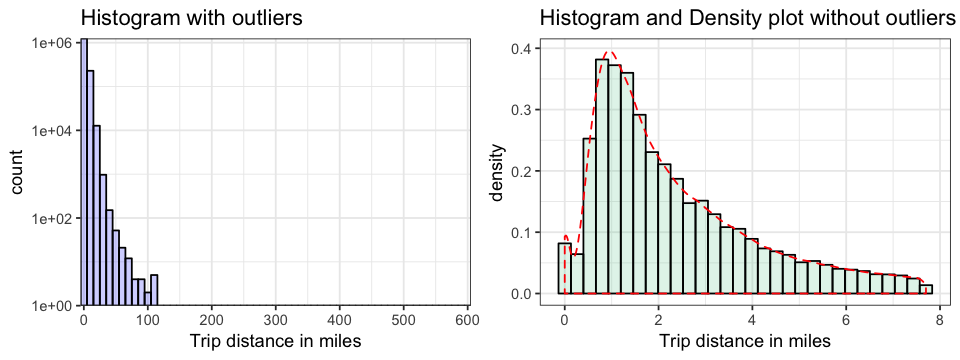

In [6]:
#Histogram of Trip distance in miles with outliers 

Histogram1 <- ggplot(data = Taxidata, aes(x = Trip_distance)) +
  geom_histogram(
    bins = 10,
    binwidth = 10,
    col = "black",
    fill = "blue",
    alpha = .2,
    position = "identity"
  ) +
  scale_x_continuous(name = 'Trip distance in miles',
                     breaks = seq(0, 600, 100),
                     expand = c(0, 0)) +
  scale_y_log10(expand = c(0, 0)) + labs(title = "Histogram with outliers") +
  theme_bw()

#Removing the ouliers using boxplot statistics

outlier <- boxplot.stats(Taxidata$Trip_distance)$out
variable <- ifelse(Taxidata$Trip_distance %in% outlier, NA, Taxidata$Trip_distance)

#Histogram of Trip distance in miles without outliers 

Histogram2 <- ggplot(Taxidata, aes(x = variable)) +
  geom_histogram(
    aes(y = ..density..),
    bins = 30,
    col = "black",
    fill = "#66CC99",
    alpha = .2,
    position = "identity"
  ) +
  scale_x_continuous(name = 'Trip distance in miles') + geom_density(alpha =.2,
                                                                     col = "red",
                                                                     linetype = "dashed") +
  theme_bw() + labs(title = "Histogram and Density plot without outliers")


#Used package "repr" to resize the plots in Jupyter notebook
options(repr.plot.width=8, repr.plot.height=3)

#Plotting the graphs using a grid
suppressWarnings(print(plot_grid(
  Histogram1, Histogram2, ncol = 2, nrow = 1
)))



In [5]:
#Printing Outlier Statistics
out1 <- sum(is.na(Taxidata$Trip_distance))
out2 <- sum(is.na(variable))

cat("Number of outliers identified:", out2 - out1, "rows","\n")
cat("Proportion (%) of outliers:", round((out2 - out1) / sum(!is.na(variable)) *
                                           100, 1), "%","\n")
cat("Mean with out removing the outliers:", round(mean(Taxidata$Trip_distance), 2),"\n")
cat("Mean after removing the outliers:", round(mean(variable, na.rm = TRUE), 2),"\n")


Number of outliers identified: 103257 rows 
Proportion (%) of outliers: 7.4 % 
Mean with out removing the outliers: 2.97 
Mean after removing the outliers: 2.34 


Report any structure found and any hypotheses about that structure.

• The Trip distance is asymmetrically distributed. The right tail is longer; the mass of the distribution is concentrated on the left of the figure. The distribution is said to be right-skewed, right-tailed, or skewed to the right. Trip distance has lognormal distribution structure.

https://en.wikipedia.org/wiki/Skewness

https://en.wikipedia.org/wiki/Log-normal_distribution

• The skewness is due to Taxi's are operated in the city mostly for daily commuting (shorter distances); As the distribution is right skewed and major distribution lies between 1-3 miles; commuters might travelling in urgency.


Mean and median trip distance grouped by hour of day.

In [8]:
#Extracting columns lpep_pickup_datetime and Trip distance
TripDistanceByTime <- Taxidata[, c(2, 11)]
#Converting lpep_pickup_datetime in to date format
TripDistanceByTime[, 1] <- as.POSIXct(strptime(TripDistanceByTime[, 1], "%Y-%m-%d %H:%M:%S"))
#Extract hour from the lpep_pickup_datetime
TripDistanceByTime$hour <- hour(TripDistanceByTime[, 1])
TripDistanceByTime$lpep_pickup_datetime <- NULL

#Reshaping data
mlt <- melt(TripDistanceByTime, id = c("hour"))
res_mean <- dcast(mlt, hour ~ variable, mean)
res_median <- dcast(mlt, hour ~ variable, median)
Trip_mean_median <- cbind(res_mean, res_median$Trip_distance)
names(Trip_mean_median) <- c("Hour", "Mean_Trip_distance", "Median_Trip_distance")

cat("mean and median trip distance grouped by hour of day\n")
print(Trip_mean_median)



mean and median trip distance grouped by hour of day
   Hour Mean_Trip_distance Median_Trip_distance
1     0           3.115276                 2.20
2     1           3.017347                 2.12
3     2           3.046176                 2.14
4     3           3.212945                 2.20
5     4           3.526555                 2.36
6     5           4.133474                 2.90
7     6           4.055149                 2.84
8     7           3.284394                 2.17
9     8           3.048450                 1.98
10    9           2.999105                 1.96
11   10           2.944482                 1.92
12   11           2.912015                 1.88
13   12           2.903065                 1.89
14   13           2.878294                 1.84
15   14           2.864304                 1.83
16   15           2.857040                 1.81
17   16           2.779852                 1.80
18   17           2.679114                 1.78
19   18           2.653222         

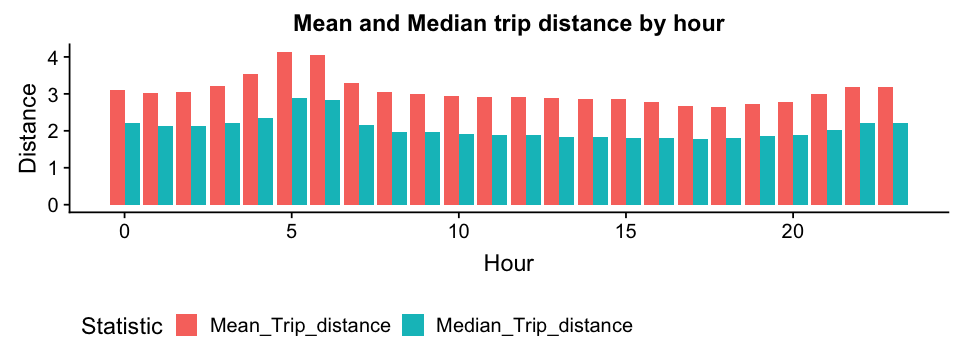

In [9]:
#Pivoting the data using melt function
pmlt <-
  melt(
    Trip_mean_median,
    id.vars = "Hour",
    value.name = "value",
    variable.name = "Statistic"
  )

barplot <- ggplot(pmlt, aes(x = Hour, y = value, fill = Statistic)) + geom_bar(position = "dodge", stat = "identity") +
  theme(legend.position = "bottom") +
  labs(title = "Mean and Median trip distance by hour", y = "Distance")

options(repr.plot.width=8, repr.plot.height=3)
plot(barplot)



# A tibble: 6 x 3
# Groups:   Trip_hour [1]
  Trip_hour Trip_week_day meandist
      <int>         <dbl>    <dbl>
1         0             1     3.33
2         0             2     3.43
3         0             3     3.11
4         0             4     3.23
5         0             5     3.30
6         0             6     3.16


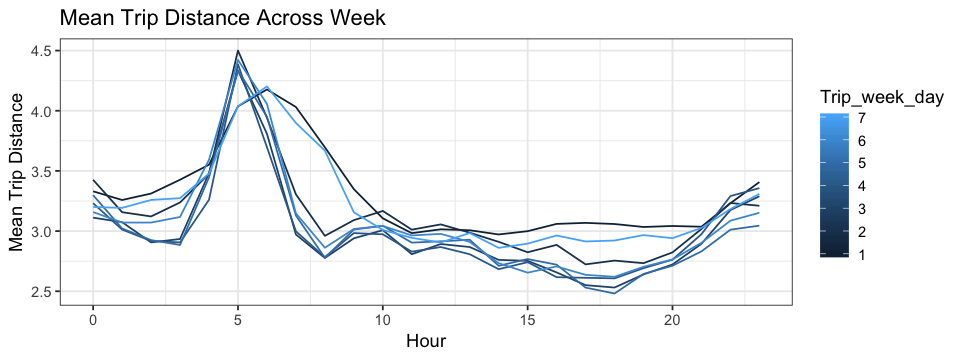

In [25]:
#Line chart to see how the trip distance is changing with time for different days of week

MeanDist <- Taxidata[, c(3, 11)]

MeanDist$Lpep_dropoff_datetime <- as.POSIXct(strptime(MeanDist[, 'Lpep_dropoff_datetime'], "%Y-%m-%d %H:%M:%S"))
MeanDist$Trip_hour <- hour(MeanDist$Lpep_dropoff_datetime)
MeanDist$Trip_week_day <- wday(MeanDist$Lpep_dropoff_datetime)   

levels(MeanDist$Trip_week_day) <- c("Sunday", "Monday", "Tuesday", "Wednesday",
                                    "Thursday", "Friday", "Saturday")

test <- MeanDist %>% 
       filter(Trip_distance<200) %>%
       group_by(Trip_hour, Trip_week_day) %>%
       summarize(
                 meandist = mean(Trip_distance, na.rm=TRUE)
           )

print(head(test))

lineplot <- ggplot(test, aes(x=Trip_hour, y=meandist, group = Trip_week_day, color=Trip_week_day)) +
geom_line()+
  theme_bw() +
  labs(title = "Mean Trip Distance Across Week") +
  labs(x = "Hour", y = "Mean Trip Distance") +
  scale_fill_discrete(name = "Day of Week")

options(repr.plot.width=8, repr.plot.height=3)
plot(lineplot)
     

The Taxidata consists of Payment_type provided in numeric code signifying how the passenger paid for the trip. From data dictionaries http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf we can infer payment type.

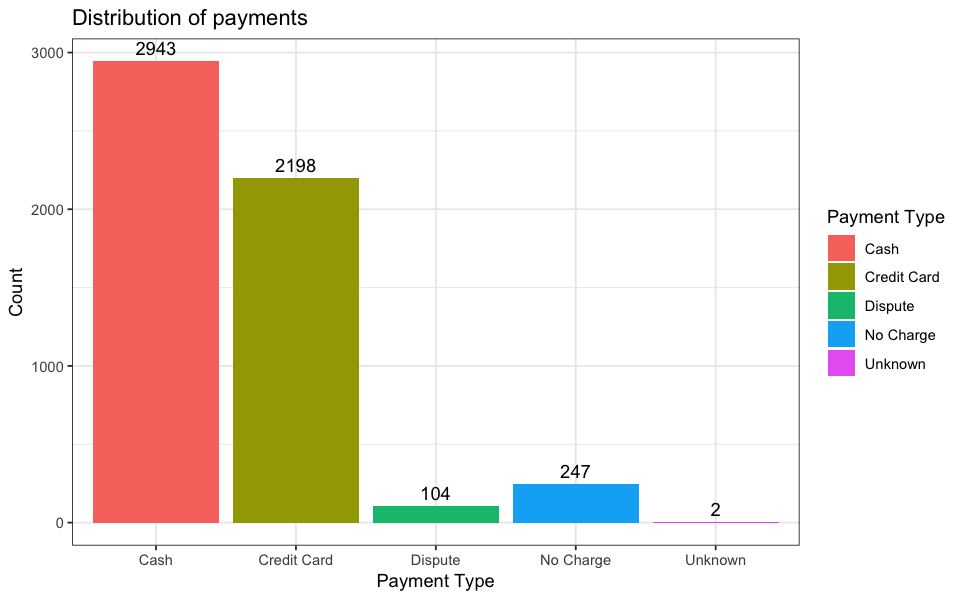

In [9]:
# Distribution of payments

AirportData$Payment_type[AirportData$Payment_type == 1] <- "Credit Card"
AirportData$Payment_type[AirportData$Payment_type == 2] <- "Cash"
AirportData$Payment_type[AirportData$Payment_type == 3] <- "No Charge"
AirportData$Payment_type[AirportData$Payment_type == 4] <- "Dispute"
AirportData$Payment_type[AirportData$Payment_type == 5] <- "Unknown"
AirportData$Payment_type[AirportData$Payment_type == 6] <- "Voided Trip"

type <- data.frame(table(AirportData$Payment_type))

options(repr.plot.width=8, repr.plot.height=5)
ggplot(type, aes(
  x = Var1,
  y = Freq,
  fill = Var1,
  label = Var1
)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = Freq), vjust = -0.5) +
  theme_bw() +
  labs(title = "Distribution of payments") + labs(x = "Payment Type", y =
                                                    "Count") +
  scale_fill_discrete(name = "Payment Type")

In [ ]:
Identifying trips that originate or terminate at one of the NYC area airports. 

Count of how many transactions fit this criteria, the average fair, 
and any other interesting characteristics of these trips.

From the data dictionary we can infer that there are two airports JFK and Newark
which are represented by RateCodeID 2 and 3 respectively.

In [13]:
#The final rate code in effect at the end of the trip.
# 2=JFK
# 3=Newark

AirportData <- Taxidata %>%
  filter(
    RateCodeID %in% c(2, 3) &
      Pickup_longitude != 0 &
      Pickup_latitude != 0 &
      Dropoff_longitude != 0 & Dropoff_latitude != 0
  )

AirportData$RateCodeLocation <- AirportData[, 'RateCodeID']
AirportData$RateCodeLocation <- ifelse(AirportData$RateCodeLocation == 2, "JFK", "Newark")

cat("Number of trips originate or terminate at oneof the NYC area airports:", nrow(AirportData),"\n")
cat("Average fair of the trips originate or terminate at one of the NYC area airports:$",mean(AirportData$Fare_amount),"\n")
cat("Average tip amount given by the customers: $",mean(AirportData$Tip_amount),"\n")
cat("Average total amount of the trips originate or terminate at one of the NYC area airports:$",mean(AirportData$Total_amount),"\n")



Number of trips originate or terminate at oneof the NYC area airports: 5494 
Average fair of the trips originate or terminate at one of the NYC area airports:$ 48.998 
Average tip amount given by the customers: $ 4.393189 
Average total amount of the trips originate or terminate at one of the NYC area airports:$ 57.29616 


Warning message:
"attributes are not identical across measure variables; they will be dropped"

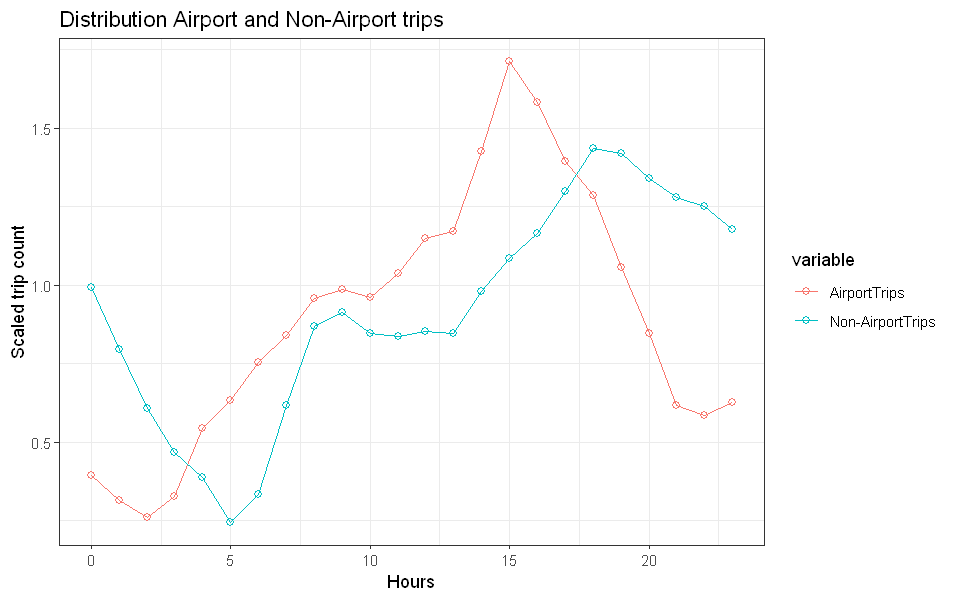

In [69]:
#Hourly trip distributions Airport vs Non-Airport.

TripDistributions <- Taxidata[, c("lpep_pickup_datetime", 'Trip_distance', 'RateCodeID')]
TripDistributions[, 1] <- as.POSIXct(strptime(TripDistributions[, 1], "%Y-%m-%d %H:%M:%S"))
TripDistributions$hour <- hour(TripDistributions[, 1])

TripDistributions$Trip_Type <-
  ifelse(
    TripDistributions$RateCodeID == 2 |
      TripDistributions$RateCodeID == 3,
    "Airport trip",
    "Non-Airport trip"
  )

Trips <- sqldf('select hour,Trip_Type,count(Trip_Type) as TripNum from TripDistributions group by hour,Trip_Type order by Trip_type ')

AirportTrips <- Trips[1:24, ]
NonAirportTrips <- Trips[25:48, ]

AirTrips <- data.frame(cbind(AirportTrips$hour,AirportTrips$TripNum, NonAirportTrips$TripNum))
names(AirTrips) <- c('Hours', 'AirportTrips', 'Non-AirportTrips')

#standardize the range of independent variables between Airport and Non-Airport trips
AirTrips$AirportTrips <- scale(AirTrips$AirportTrips, center = FALSE, scale = TRUE)
AirTrips$`Non-AirportTrips` <- scale(AirTrips$`Non-AirportTrips`,center = FALSE,scale = TRUE)

#pivoting the data
AirTripsdata <- melt(AirTrips, id.vars = 'Hours')

options(repr.plot.width=8, repr.plot.height=5)

#Line plot to identify the distribution of Airports vs Non-Airport trips
ggplot(data = AirTripsdata, aes(
  x = Hours,
  y = value,
  group = variable,
  colour = variable
)) +
  geom_line() + geom_point(size = 2, shape = 1) +
  theme_bw() +
  labs(title = "Distribution Airport and Non-Airport trips") +
  labs(x = "Hours", y = "Scaled trip count") +
  scale_fill_discrete(name = "Trip type")


• Build a derived variable for tip as a percentage of the total fare.

I have taken absolute values of Total_amount and Tip_amount to eliminate the negitive values which might caused by an error.Also, I assumed that minimum charge for the trip shouldnot be less than 2.5 (source : http://nyc.taxiwiz.com/fare.php?lang=en) and replaced the values which are less than the 2.5 with median of the Total_amount.

In [10]:
Taxidata$Total_amount <- abs(Taxidata$Total_amount)
Taxidata$Tip_amount <- abs(Taxidata$Tip_amount)
Taxidata$Total_amount <- ifelse(Taxidata$Total_amount < 2.5,median(Taxidata$Total_amount),Taxidata$Total_amount)
Taxidata$Tip_percent <- (Taxidata$Tip_amount/Taxidata$Total_amount)* 100

In [27]:
cat('Summary statistics of tip percentage')
print(summary(Taxidata$Tip_percent))

cat('Preview of dataset with tip percentage')
print(head(Taxidata))

Summary statistics of tip percentage   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   6.635  16.667 100.000 
Preview of dataset with tip percentage  VendorID lpep_pickup_datetime Lpep_dropoff_datetime Store_and_fwd_flag
1        2  2015-09-01 00:02:34   2015-09-01 00:02:38                  N
2        2  2015-09-01 00:04:20   2015-09-01 00:04:24                  N
3        2  2015-09-01 00:01:50   2015-09-01 00:04:24                  N
4        2  2015-09-01 00:02:36   2015-09-01 00:06:42                  N
5        2  2015-09-01 00:00:14   2015-09-01 00:04:20                  N
6        2  2015-09-01 00:00:39   2015-09-01 00:05:20                  N
  RateCodeID Pickup_longitude Pickup_latitude Dropoff_longitude
1          5        -73.97948        40.68496         -73.97943
2          5        -74.01080        40.91222         -74.01078
3          1        -73.92141        40.76671         -73.91441
4          1        -73.92139        40.76668         -73.931

I divided the entire predictive modelling process into three steps.

    • Data cleaning : To eleminate outliers, missing values, data type conversion
    • Feature engineering : Create features to help machine learning algorithms to work better and efficiently
    • Model building:  Building predictive models

#### Data Cleaning 

    • converting the variables Lpep_dropoff_datetime,lpep_pickup_datetime in to date time classes.
    • Droped the variables (Ehail_fee) which has near zero variance.
    • RateCodeID has invalid numeric 99 which was replaced by 1
    • Extra any values other than 0.5 or 1 are replaced by 0
    • Total_amount, Fare_amount, Tip_amount ,improvement_surcharge has negitive values which might be caused by                error so we have taken the absolute values of respective variables.
    • Null values in Trip_type are replaced by 1
    • Trip_distance with negative values are replaced by median of Trip_distance.

In [11]:
#Data Cleaning
Taxidata$lpep_pickup_datetime <- as.POSIXct(strptime(Taxidata[, 'lpep_pickup_datetime'], "%Y-%m-%d %H:%M:%S"))
Taxidata$Lpep_dropoff_datetime <- as.POSIXct(strptime(Taxidata[, 'Lpep_dropoff_datetime'], "%Y-%m-%d %H:%M:%S"))
Taxidata$RateCodeID <- ifelse(Taxidata$RateCodeID==99,1,Taxidata$RateCodeID)
Taxidata$Fare_amount <- abs(Taxidata$Fare_amount)

Taxidata$Extra <- abs(Taxidata$Extra)
Taxidata$Extra <- ifelse(Taxidata$Extra==0.5|Taxidata$Extra==1,Taxidata$Extra,0)

Taxidata$MTA_tax <- abs(Taxidata$MTA_tax)
Taxidata$Tip_amount <- abs(Taxidata$Tip_amount)
Taxidata$Tolls_amount <- abs(Taxidata$Tolls_amount)
Taxidata$improvement_surcharge <- abs(Taxidata$improvement_surcharge)
Taxidata$Total_amount <- abs(Taxidata$Total_amount)
Taxidata$Total_amount <- ifelse(Taxidata$Total_amount < 2.5,median(Taxidata$Total_amount),Taxidata$Total_amount)
Taxidata$Ehail_fee <- NULL
Taxidata$Trip_type[is.na(Taxidata$Trip_type)]<- 1
Taxidata$Trip_distance <- ifelse(Taxidata$Trip_distance>0,Taxidata$Trip_distance,1.980)

#### Feature Engineering

In Feature engineering stage I created new variables from current variables.

     • Time variables: Weekday, Week Number, Day number, Trip hour
     • Trip duration: calculated the trip duration by diffrence between trip pick up and drop off timmings. 
       If the trip duration is 0 or less than 0, I replaced the values by median of the Trip duration.
     • Trip speed: Trip speed is calculated ratio between Trip distance to Trip duration in mins.
     • outlier removal function to eliminate outliers.
     • random.imp function to replace the NA values with random variables maintaining the distribution.
     

In [12]:
#Feature Engineering
#Date variables
#Trip duration
#Speed calculation

#computing date variables
Taxidata$Trip_week_day <- wday(Taxidata$lpep_pickup_datetime)
Taxidata$Trip_weekNumber <- isoweek(Taxidata$lpep_pickup_datetime)
Taxidata$Trip_dayNumber <- day(Taxidata$lpep_pickup_datetime)
Taxidata$Trip_hour <- hour(Taxidata$lpep_pickup_datetime)

#computing trip duration
Taxidata$Trip_duration <- as.numeric(difftime(Taxidata$Lpep_dropoff_datetime,Taxidata$lpep_pickup_datetime,units = "mins"))
Taxidata$Trip_duration <- ifelse(Taxidata$Trip_duration==0,median(Taxidata$Trip_duration),Taxidata$Trip_duration)

#Speed calculation
Taxidata$Trip_speed <- (Taxidata$Trip_distance)/(Taxidata$Trip_duration/60)

#Outlier removal function
remove_outliers <- function(x, na.rm = TRUE, ...) {
  qnt <- quantile(x, probs=c(.25, .75), na.rm = na.rm, ...)
  H <- 1.5 * IQR(x, na.rm = na.rm)
  y <- x
  y[x < (qnt[1] - H)] <- NA
  y[x > (qnt[2] + H)] <- NA
  y
}

Taxidata$Trip_speed <- remove_outliers(Taxidata$Trip_speed)

#Random data generator with same distribution of data
random.imp <- function (a){
  missing <- is.na(a)
  n.missing <- sum(missing)
  a.obs <- a[!missing]
  imputed <- a
  imputed[missing] <- sample (a.obs, n.missing, replace=TRUE)
  return (imputed)
}


Taxidata$Trip_speed <- random.imp(Taxidata$Trip_speed)

print(summary(Taxidata$Trip_speed))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6745  9.3182 11.5862 12.1309 14.4152 24.0647 


In [13]:
#Print the dataset dimenstions after feature engineering
cat("Number of rows after feature engineering:",nrow(Taxidata),"rows\n")
cat("Number of columns after feature engineering:",ncol(Taxidata),"columns")

Number of rows after feature engineering: 1494926 rows
Number of columns after feature engineering: 27 columns

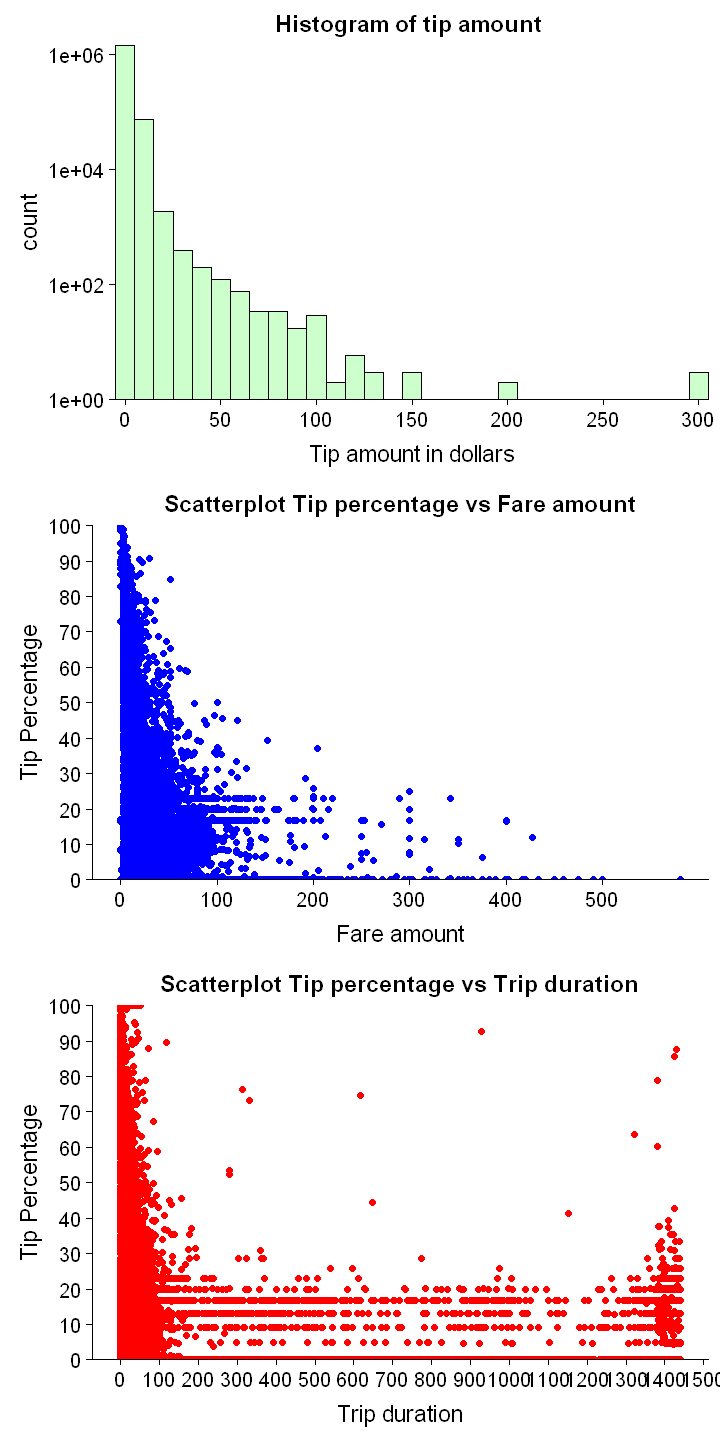

In [75]:
Histogram3 <- ggplot(data = Taxidata, aes(Tip_amount)) +
  geom_histogram(
    bins = 30,
    binwidth = 10,
    position = "identity",
    col = 'black',
    fill = "green",
    alpha = .2
  ) +
  scale_x_continuous(breaks = seq(0, 300, 50),
                     name = 'Tip amount in dollars',
                     expand = c(0, 0)) + scale_y_log10(expand = c(0, 0))+
  labs(title = "Histogram of tip amount ")

Scatter1 <- ggplot(data=Taxidata,aes(x=Fare_amount,y=Tip_percent))+geom_point(stat = 'identity',inherit.aes = TRUE,col = 'blue')+
  scale_y_continuous(breaks = seq(0, 100, 10),
                     name = 'Tip Percentage',
                     expand = c(0, 0))+
  scale_x_continuous(breaks =seq(0, 580, 100),name='Fare amount')+
  labs(title = "Scatterplot Tip percentage vs Fare amount")


scatter2 <- ggplot(Taxidata,aes(Trip_duration,Tip_percent))+geom_point(stat = 'identity',inherit.aes = TRUE,col = 'red')+
  scale_y_continuous(breaks = seq(0, 100, 10),
                     name = 'Tip Percentage',
                     expand = c(0, 0))+
  scale_x_continuous(breaks =seq(0, 1500, 100),name='Trip duration')+
  labs(title = "Scatterplot Tip percentage vs Trip duration")

options(repr.plot.width=6, repr.plot.height=12)

suppressWarnings(print(plot_grid(
  Histogram3, Scatter1,scatter2, ncol = 1, nrow = 3
)))


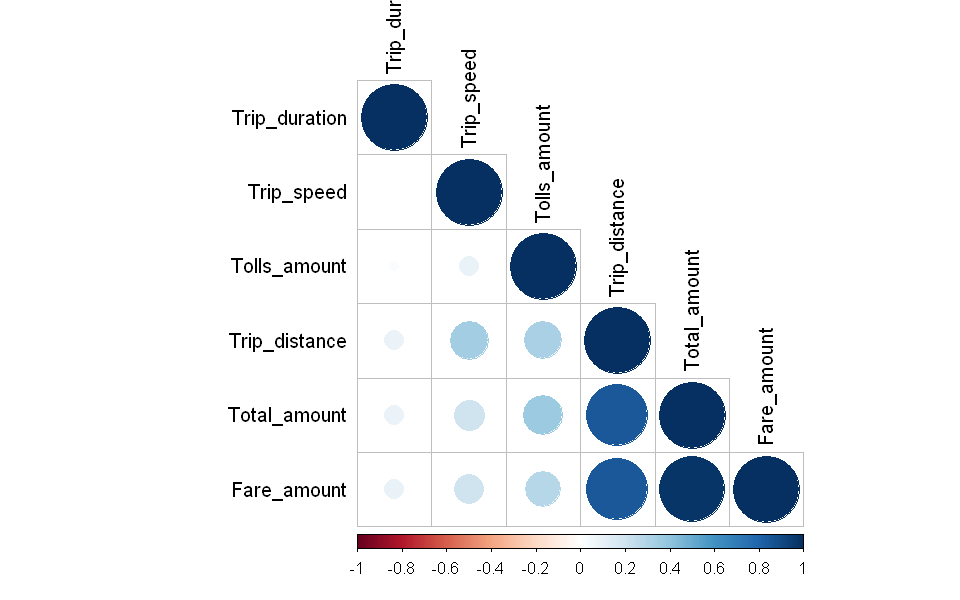

In [76]:
#Correlation between continues variables

vars <- c('Total_amount','Fare_amount','Trip_distance','Trip_duration','Tolls_amount','Trip_speed','Tip_percent')
numericdata <- Taxidata[,vars]
corr <- cor(numericdata[,1:ncol(numericdata)-1])

options(repr.plot.width=8, repr.plot.height=5)
corrplot(corr,type="lower",order = "hclust",tl.col = "black")

I can identify high correlation between Fare_amount vs Total_amount, Trip_distance vs Fare_amount vs Total_amount, Trip_distance vs Trip_speed.

In [14]:
Taxidata$Tipped <- ifelse(Taxidata$Tip_amount>0,1,0)
tab <- table(Taxidata$Payment_type,Taxidata$Tipped)
colnames(tab) <- c("Not Tipped","Tipped")
row.names(tab) <- c("Credit card","Cash","No Charge","Dispute","Unknown")
cat('PaymentType vs Tip')
print(tab)

PaymentType vs Tip             
              Not Tipped Tipped
  Credit card      98557 602730
  Cash            783697      2
  No Charge         5463     35
  Dispute           4365      3
  Unknown             74      0


Above distribution shows that 99% transactions with tips were paid are done by payment method Credit card. Which will be really helpful to classify a customer whether will tip or not.

In [33]:
print(names(Taxidata))
print(str(Taxidata))

 [1] "VendorID"              "lpep_pickup_datetime"  "Lpep_dropoff_datetime"
 [4] "Store_and_fwd_flag"    "RateCodeID"            "Pickup_longitude"     
 [7] "Pickup_latitude"       "Dropoff_longitude"     "Dropoff_latitude"     
[10] "Passenger_count"       "Trip_distance"         "Fare_amount"          
[13] "Extra"                 "MTA_tax"               "Tip_amount"           
[16] "Tolls_amount"          "improvement_surcharge" "Total_amount"         
[19] "Payment_type"          "Trip_type"             "Trip_week_day"        
[22] "Trip_weekNumber"       "Trip_dayNumber"        "Trip_hour"            
[25] "Trip_duration"         "Trip_speed"            "Tipped"               
[28] "Tip_percent"          
'data.frame':	1494926 obs. of  28 variables:
 $ VendorID             : int  2 2 2 2 2 2 2 2 2 2 ...
 $ lpep_pickup_datetime : POSIXct, format: "2015-09-01 00:02:34" "2015-09-01 00:04:20" ...
 $ Lpep_dropoff_datetime: POSIXct, format: "2015-09-01 00:02:38" "2015-09-01 00:04:24" 

#### • Model building

To Build a predictive model for tip as a percentage of the total fare, The model will be a combination of classification model and a regression model.

• Classification model- To classify a user whether tipped or not 

• Regression model - To predict tip percentage of the user provided that he classified as tipped in classification model 

##### Classification model

    • For building classification model I have considered dependent variables such as Total_amount, Payment_type, Trip_hour, Trip_week_day, Trip_speed, Extra, MTA_tax.
    • Created a target variable "tipped" based upon whether customer tipped or not.
    • Tried logistic regression, randomforest, gradient boosting methods to classify the transaction tipped or not.
    • I have considered 80% of the data for training the model which maintains the similar distribution of the entire dataset and considered rest 10% as the testing dataset.
    • Build object control parameter for k-fold cross validation with 5 folds.
    • Build a grid for tuning parameters such as interaction depth, number of trees, min nodes, shrinkage.
    • Build a gbm model using object control, grid and centered and scaled to normalize the data, accuracy as evaluation metric
    • Plotted the ROC to illustrate the performance of the model and Variable Importance to know the important variables.
    • Evaluated GBM model on testing dataset with Accuracy and Kappa measures.

In [20]:
registerDoSEQ()

trainData <- Taxidata
#trainData$Payment_type <- as.factor(trainData$Payment_type)
#trainData$VendorID <- as.factor(trainData$VendorID)

Vars <- c("Extra","MTA_tax","Total_amount","Payment_type",
                    "Trip_duration","Trip_hour","Trip_week_day","Trip_speed","Tipped")
data <- trainData[,Vars]
data$Tipped <- as.factor(data$Tipped)
levels(data$Tipped) <- make.names(levels(factor(data$Tipped)))

predictors <- c("Extra","MTA_tax","Total_amount","Payment_type",
                        "Trip_duration","Trip_hour","Trip_week_day","Trip_speed")

outcome <- c('Tipped')

set.seed(128)

trainIndex <- createDataPartition(data$Tipped, p =.8,list =FALSE)
training <- data[trainIndex,]
testing <- data[-trainIndex,]

#basic parameter tuning
objControl <- trainControl(method='cv', 
                           number=5, 
                           returnResamp='none', 
                           summaryFunction = twoClassSummary, 
                           classProbs = TRUE)

gbmGrid <- expand.grid(interaction.depth = (1:5) * 2,
                     n.trees = seq(1,150,5),
                     n.minobsinnode =2,
                    shrinkage = .1)

#fitControl

fit.gbm1 <- suppressWarnings(train(training[,predictors] ,training[,outcome],
                method='gbm',
                metric="Accuracy",
                preProc = c("center","scale"),
                trControl=objControl,
                tuneGrid = gbmGrid
                ))



Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2015             nan     0.1000    0.0736
     2        1.0818             nan     0.1000    0.0598
     3        0.9828             nan     0.1000    0.0495
     4        0.8998             nan     0.1000    0.0416
     5        0.8295             nan     0.1000    0.0352
     6        0.7695             nan     0.1000    0.0300
     7        0.7180             nan     0.1000    0.0257
     8        0.6737             nan     0.1000    0.0222
     9        0.6353             nan     0.1000    0.0192
    10        0.6019             nan     0.1000    0.0167
    20        0.4296             nan     0.1000    0.0046
    40        0.3576             nan     0.1000    0.0010
    60        0.3375             nan     0.1000    0.0003
    80        0.3255             nan     0.1000    0.0001
   100        0.3159             nan     0.1000    0.0002
   120        0.3076             nan     0.1000    0.0000
   140        

ROC Curve

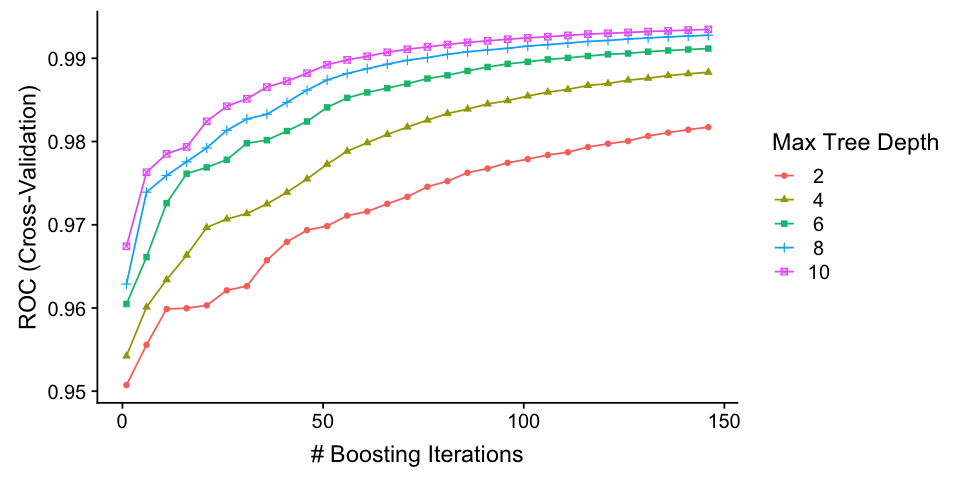

In [22]:
Rocplot <- ggplot(fit.gbm1) 

cat('ROC Curve')
options(repr.plot.width=8, repr.plot.height=4)
suppressWarnings(Rocplot)

                        var      rel.inf
Payment_type   Payment_type 86.023844569
Total_amount   Total_amount  5.979738681
Trip_duration Trip_duration  5.285250882
Trip_speed       Trip_speed  1.492303875
MTA_tax             MTA_tax  0.825721138
Extra                 Extra  0.389399472
Trip_hour         Trip_hour  0.003741384
Trip_week_day Trip_week_day  0.000000000


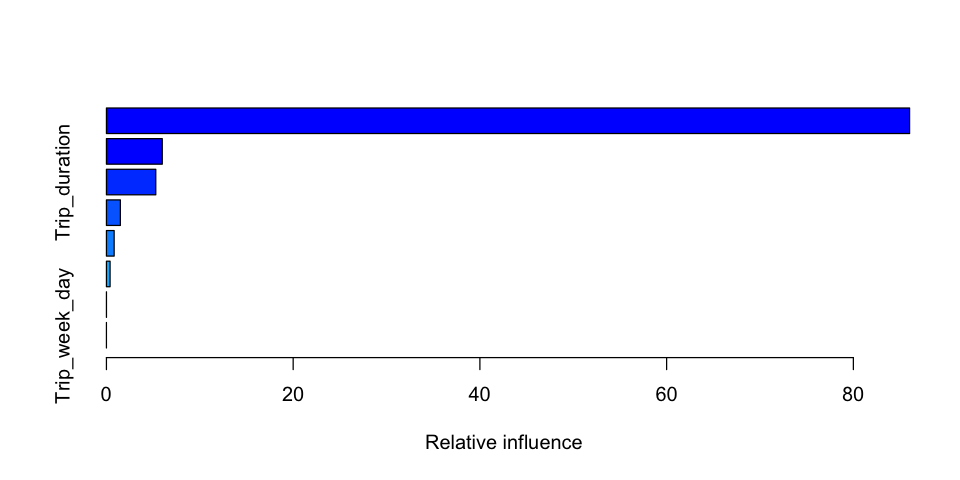

In [23]:
print(summary(fit.gbm1))

In [24]:
# make predictions - gbm
xgbmtest <- testing[,predictors]
ygbmtest <- testing[,outcome]
predictions <- predict(fit.gbm1, xgbmtest)

print(summary(predictions))

pred <- ifelse(predictions == 'X0', 0, 1)
actual <- ifelse(ygbmtest == 'X0', 0, 1)

#print(head(predictions))
#print(head(pred))
#print(head(ygbmtest))
#print(head(actual))

print(confusionMatrix(pred, actual))


    X0     X1 
170281 128704 
       [,1]   [,2]
[1,] 169274   9157
[2,]   1007 119547


In [25]:
#Accuracy of GBM 
print((169274 + 119547)/nrow(testing))

#AUC of GBM
print(auc(pred, actual))

[1] 0.966005
[1] 0.9614692


In [27]:
registerDoSEQ()

trainData <- Taxidata
#trainData$Payment_type <- as.factor(trainData$Payment_type)
#trainData$VendorID <- as.factor(trainData$VendorID)

Vars <- c("Extra","MTA_tax","Total_amount","Payment_type",
                    "Trip_duration","Trip_hour","Trip_week_day","Trip_speed","Tipped")
data <- trainData[,Vars]
data$Tipped <- as.factor(data$Tipped)
levels(data$Tipped) <- make.names(levels(factor(data$Tipped)))

predictors <- c("Extra","MTA_tax","Total_amount","Payment_type",
                        "Trip_duration","Trip_hour","Trip_week_day","Trip_speed")

outcome <- c('Tipped')

set.seed(128)

trainIndex <- createDataPartition(data$Tipped, p =.8,list =FALSE)
training <- data[trainIndex,]
testing <- data[-trainIndex,]


#basic parameter tuning
objControl <- trainControl(method='cv', 
                           number=5, 
                           returnResamp='none', 
                           summaryFunction = twoClassSummary, 
                           classProbs = TRUE)
mtry <- sqrt(ncol(testing))
tunegrid <- expand.grid(.mtry=c(4,6,8,10))


fit.RF <- suppressWarnings(train(training[,predictors] ,training[,outcome],
                method='rf',
                metric="Accuracy",
                preProc = c("center","scale"),
                trControl=objControl,
                tuneGrid = tunegrid
                ))

Random Forest 

149493 samples
     8 predictor
     2 classes: 'X0', 'X1' 

Pre-processing: centered (8), scaled (8) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 119595, 119595, 119593, 119595, 119594 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   4    0.9975345  0.9736594  0.9837583
   6    0.9977668  0.9771341  0.9808882
   8    0.9976592  0.9774704  0.9790634
  10    0.9976682  0.9775601  0.9791297

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 6.


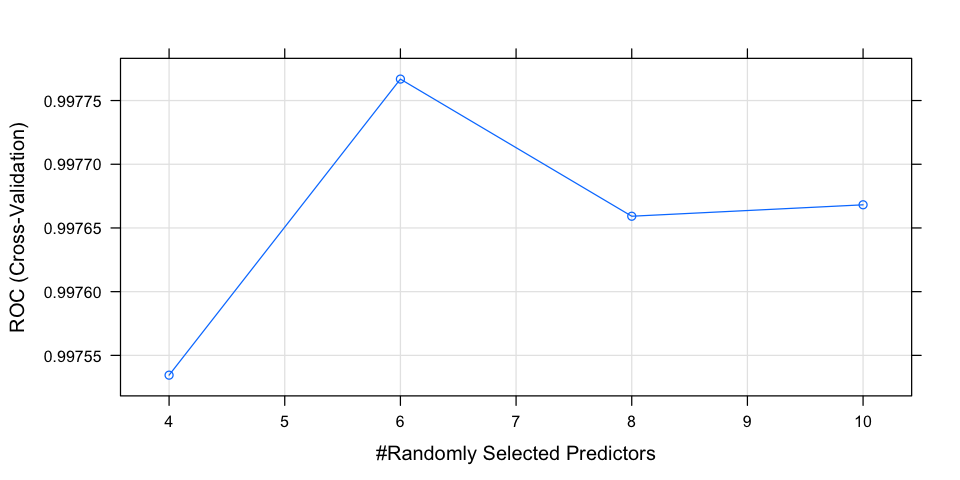

In [28]:
print(fit.RF)
plot(fit.RF)

In [51]:
# make predictions - Random Forest
xRFtest <- testing[,predictors]
yRFtest <- testing[,outcome]
predictions <- predict(fit.RF, xRFtest)

print(summary(predictions))

pred <- ifelse(predictions == 'X0', 0, 1)
actual <- ifelse(yRFtest == 'X0', 0, 1)

#print(head(predictions))
#print(head(pred))
#print(head(ygbmtest))
#print(head(actual))

print(confusionMatrix(pred, actual))
print(auc(pred, actual))


    X0     X1 
795612 549821 
       [,1]   [,2]
[1,] 785469  17471
[2,]  10143 532350
[1] 0.9777378


In [52]:
#Accuracy of Random Forest 
print((785469 + 532350)/nrow(testing))

[1] 0.9794758


In [17]:
registerDoSEQ()
trainData <- Taxidata
Vars <- c("Extra","MTA_tax","Total_amount","Payment_type",
                    "Trip_duration","Trip_hour","Trip_week_day","Trip_speed","Tipped")
data <- trainData[,Vars]

trainIndex <- createDataPartition(data$Tipped, p =.8,list =FALSE)
logistic_train <- data[trainIndex,]
logistic_test <- data[-trainIndex,]

#Logistic Regression Model

fit.logistic <- glm(Tipped ~ Extra + MTA_tax + Total_amount + Payment_type +
                        Trip_duration + Trip_hour +Trip_week_day + Trip_speed, 
                      data=training, family="binomial")


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [57]:
print(summary(fit.logistic))


Call:
glm(formula = Tipped ~ Extra + MTA_tax + Total_amount + Payment_type + 
    Trip_duration + Trip_hour + Trip_week_day + Trip_speed, family = "binomial", 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.9357  -0.0104  -0.0093   0.5156   8.4904  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    1.013e+01  4.556e-01  22.234  < 2e-16 ***
Extra         -2.358e-02  3.250e-02  -0.725 0.468148    
MTA_tax        5.306e+00  1.354e-01  39.196  < 2e-16 ***
Total_amount   3.886e-02  1.235e-03  31.460  < 2e-16 ***
Payment_type  -1.155e+01  4.494e-01 -25.702  < 2e-16 ***
Trip_duration -1.025e-03  8.932e-05 -11.478  < 2e-16 ***
Trip_hour      5.524e-03  1.668e-03   3.311 0.000929 ***
Trip_week_day -1.891e-03  5.478e-03  -0.345 0.729912    
Trip_speed    -1.797e-03  2.882e-03  -0.623 0.533001    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to 

In [18]:
# make predictions
xlogistictest <- logistic_test[,predictors]
ylogistictest <- logistic_test[,outcome]

predictions <- predict(fit.logistic, xlogistictest, type="response")
print(head(predictions))

pred <- ifelse(predictions>0.5, 1, 0)
print(confusionMatrix(pred, ylogistictest))
print(auc(pred, ylogistictest))

           2            3            5            6           21           23 
5.769045e-01 8.043742e-01 4.073104e-05 8.181219e-01 4.496066e-05 8.331354e-01 
       [,1]   [,2]
[1,] 159951  18353
[2,]    623 120058
[1] 0.9317612


In [19]:
#Accuracy of Logistic Regression
print((159951 + 120058)/nrow(logistic_test))

[1] 0.9365319


##### Regression model

    • For building regression model I have considered dependent variables such as VendorID, Passenger_count, Trip_distance, Total_amount, Extra, Extra,MTA_tax,Tolls_amount,Trip_hour,Trip_week_day,Trip_weekNumber,Trip_dayNumber,Trip_duration,Trip_speed.
    • Created a target variable "tip percentage" based upon tip amount and  total fare.
    • Created a subset of data whose tip percentage is greater than '0' as this model is after classifying the user as tipped.
    • Build models such as Ridge and Lasso linear models, Random forests and gradient boosting methods to predict the tip percentage and finalized the GBM as the final model as it has the least rmse error when compared with other models.
    • Build object control parameter for k-fold cross validation with 3 folds.
    • Build a grid for tuning parameters such as interaction depth, number of trees, min nodes, shrinkage.
    • Evaluated the model on testing dataset and measured the performance using RMSE and MAE errors.
    •  Plotted the residuals histogram plot to check distribution and found that residuals are symetrically distributed.
    
    

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1       31.0816             nan     0.1000    1.4041
     2       29.6902             nan     0.1000    1.3844
     3       28.4846             nan     0.1000    1.2144
     4       27.5525             nan     0.1000    0.7994
     5       26.6415             nan     0.1000    0.7930
     6       25.9129             nan     0.1000    0.5806
     7       25.3274             nan     0.1000    0.4963
     8       24.8015             nan     0.1000    0.4686
     9       24.3040             nan     0.1000    0.4132
    10       23.8154             nan     0.1000    0.4426
    20       20.8457             nan     0.1000    0.1878
    40       17.3581             nan     0.1000    0.0734
    60       15.2144             nan     0.1000    0.0622
    80       13.7060             nan     0.1000    0.0813
   100       12.3808             nan     0.1000    0.0406
   120       11.3124             nan     0.1000    0.0281
   140       1

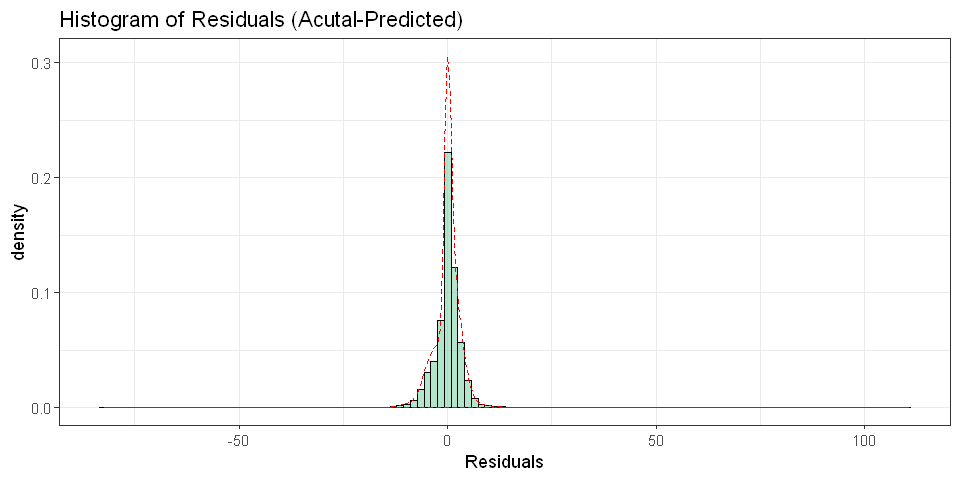

In [81]:
Reg.vars <- c('VendorID', 'Passenger_count', 'Trip_distance', 'Total_amount', 
                                'Extra', 'MTA_tax', 'Tolls_amount','Trip_hour','Trip_week_day', 'Trip_weekNumber', 'Trip_dayNumber',  
                                'Trip_duration', 'Trip_speed','Tip_percent')

Reg.predictors <- c('VendorID', 'Passenger_count', 'Trip_distance', 'Total_amount', 
                'Extra', 'MTA_tax', 'Tolls_amount','Trip_hour','Trip_week_day', 'Trip_weekNumber', 'Trip_dayNumber',  
                'Trip_duration', 'Trip_speed')

Reg.outcome <- c('Tip_percent')
reg.datasub <- subset(Taxidata,Tip_percent>0)

set.seed(230)
reg.trainIndex <- createDataPartition(reg.datasub$Tip_percent, p =.8,list =FALSE)
reg.training <- reg.datasub[reg.trainIndex,]
reg.testing <- reg.datasub[-reg.trainIndex,]

reg.trainControl <- trainControl(method="cv", number=3)

reg.gbmGrid <- expand.grid(interaction.depth = 12,
                           n.trees = 150,
                           n.minobsinnode = 13,
                           shrinkage = 0.1)

reg.fit.gbm1 <- train(Tip_percent~., data=reg.training[,Reg.vars], method="gbm", metric="RMSE",
                      trControl=reg.trainControl,tuneGrid = reg.gbmGrid)


reg.predict.gbm <- data.frame(predict(object = reg.fit.gbm1,newdata = reg.testing[,Reg.vars]))
colnames(reg.predict.gbm) <- c('Predicted Tip Percentage')
actualPredicted <- data.frame(cbind(reg.testing$Tip_percent,reg.predict.gbm))
colnames(actualPredicted) <- c('Actual Tip percentage','Predicted Tip percentage')

RMSError <- rmse(actualPredicted$`Actual Tip percentage`,actualPredicted$`Predicted Tip percentage`)
MAError <- mae(actualPredicted$`Actual Tip percentage`,actualPredicted$`Predicted Tip percentage`)
cat('RMSE Error on testing data',RMSError,'\n')
cat('Mean Absolute Error on testing data',MAError,'\n')

actualPredicted$Residuals <- (actualPredicted$`Actual Tip percentage`)-(actualPredicted$`Predicted Tip percentage`)

options(repr.plot.width=8, repr.plot.height=4)

ggplot(actualPredicted, aes(x = Residuals)) +
  geom_histogram(
    aes(y = ..density..),
    bins = 120,
    col = "black",
    fill = "#66CC99",
    alpha = .5,
    position = "identity"
  ) +
  scale_x_continuous(name = 'Residuals') + geom_density(alpha =.2,
                                                        col = "red",
                                                        linetype = "dashed") +
  theme_bw() + labs(title = "Histogram of Residuals (Acutal-Predicted)")



• Build a derived variable representing the average speed over the course of a trip.

• Trip speed was calculated earlier during feature engineering process as ratio between the distance travelled and trip duration

Trip_speed <- (Trip_distance)/(Trip_duration/60)



In [82]:
print(summary(Taxidata$Trip_speed))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6745  9.3194 11.5872 12.1310 14.4142 24.0647 


• Perform a test to determine if the average trip speeds are materially the same in all weeks of September? 


In [83]:
AvgSpeed <- sqldf("select Trip_weekNumber,avg(Trip_speed) as AvegrageSpeed from Taxidata group by Trip_weekNumber")

In [84]:
cat('Average speed over the week')
print(AvgSpeed)

Average speed over the week  Trip_weekNumber AvegrageSpeed
1              36      12.41074
2              37      11.93569
3              38      12.01239
4              39      12.33428
5              40      11.83674


##### Pairwise comparisons using t tests

Conducted pairwise comparisons using t tests with pooled SD between the week samples and identified that the null hypothesis is True i.e mean between the all samples are same.

Pairwise t test:
	Pairwise comparisons using t tests with pooled SD 

data:  Taxidata$Trip_speed and Taxidata$Trip_weekNumber 

   36      37      38      39     
37 < 2e-16 -       -       -      
38 < 2e-16 3.4e-15 -       -      
39 7.9e-14 < 2e-16 < 2e-16 -      
40 < 2e-16 7.9e-14 < 2e-16 < 2e-16

P value adjustment method: holm 


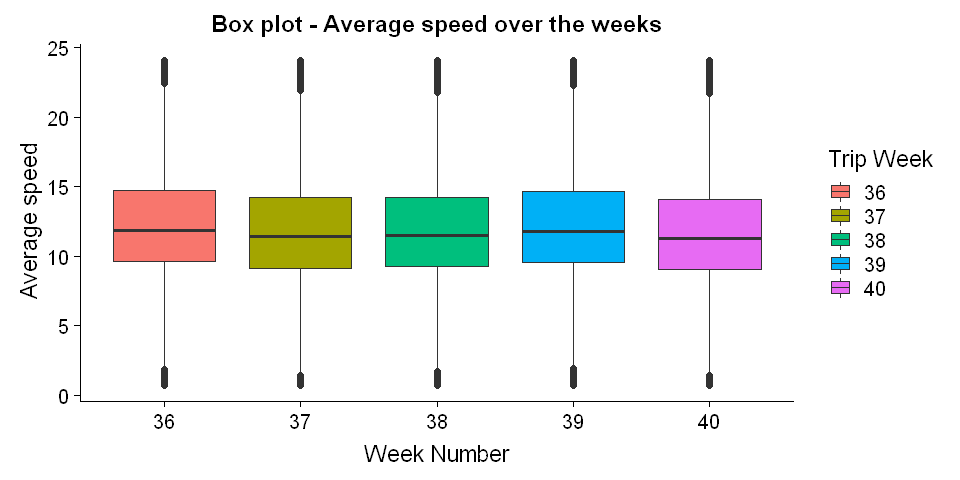

In [85]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(Taxidata, aes(x=Trip_weekNumber, y=Trip_speed,group=Trip_weekNumber,fill=as.factor(Trip_weekNumber))) + 
  geom_boxplot()+
  labs(title="Box plot - Average speed over the weeks",x="Week Number", y = " Average speed")+scale_fill_discrete(name = "Trip Week")


cat('Pairwise t test:')
print(pairwise.t.test(Taxidata$Trip_speed,Taxidata$Trip_weekNumber))

As I treated the outliers, missing values the mean speed among all weeks are same. so here we can't reject the null hypothesis and we can conclude the average trip speed between all the weeks are same. 

Build up a hypothesis of average trip speed as a function of time of day?

    • Found the average speed by trip hour for the Taxidata set.
    • Conducted anova and pairwise t tests.
    • Created a boxplot for average speed over the hours.

In [86]:
avgspeed <- sqldf("select Trip_hour,avg(Trip_speed) as AvegrageSpeed from Taxidata group by Trip_hour order by Trip_hour")


In [87]:
print(avgspeed)

   Trip_hour AvegrageSpeed
1          0      13.40688
2          1      13.58550
3          2      13.73633
4          3      13.81717
5          4      13.86800
6          5      14.44137
7          6      14.32074
8          7      12.33756
9          8      11.49174
10         9      11.72823
11        10      11.77563
12        11      11.57042
13        12      11.53313
14        13      11.50132
15        14      11.20818
16        15      10.98359
17        16      10.80420
18        17      10.80924
19        18      11.29885
20        19      11.74568
21        20      12.25202
22        21      12.81438
23        22      13.11181
24        23      13.28151


In [88]:
HourAvgSpeed.anova <- aov(Taxidata$Trip_speed~Taxidata$Trip_hour)
print(summary(HourAvgSpeed.anova))

                        Df   Sum Sq Mean Sq F value Pr(>F)    
Taxidata$Trip_hour       1   168146  168146   10174 <2e-16 ***
Residuals          1494924 24707783      17                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [89]:
Hourly.pairwise <- pairwise.t.test(Taxidata$Trip_speed,Taxidata$Trip_hour)
print(Hourly.pairwise)


	Pairwise comparisons using t tests with pooled SD 

data:  Taxidata$Trip_speed and Taxidata$Trip_hour 

   0       1       2       3       4       5       6       7       8      
1  1.1e-13 -       -       -       -       -       -       -       -      
2  < 2e-16 9.3e-08 -       -       -       -       -       -       -      
3  < 2e-16 2.6e-15 0.06176 -       -       -       -       -       -      
4  < 2e-16 < 2e-16 0.00035 0.77005 -       -       -       -       -      
5  < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 -       -       -       -      
6  < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 0.03291 -       -       -      
7  < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 -       -      
8  < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 -      
9  < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16
10 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16
11 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 < 2e-16 0.

In Anova, Pairwise t tests my hypothesis of average trip speed between all the hours are same is rejected at 5% level of significance

The boxplot also shows us speed is different in different hours. The speed is higher in early mornings and getting slow in the evenings. I can conclude that the speed depends on the hour.

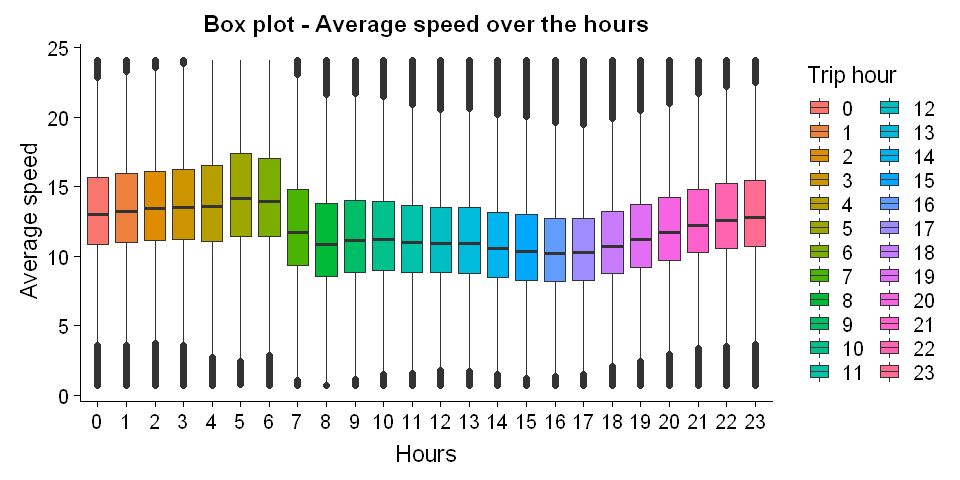

In [90]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(Taxidata, aes(x=as.factor(Trip_hour), y=Trip_speed,group=as.factor(Trip_hour),fill=as.factor(Trip_hour))) + 
  geom_boxplot()+
  labs(title="Box plot - Average speed over the hours",x="Hours", y = " Average speed")+scale_fill_discrete(name = "Trip hour")


In [91]:
stopCluster(cl)